Load models & data

In [2]:
import torch
torch.manual_seed(1337)

from models.rabignn_without_regularization import PLModule
from models.sota.gdd.wrapper import GasDistributionDecoder
from models.sota.kernel_dmv.wrapper import KernelDMV
from models.sota.dares.wrapper import Dares

from data.synthetic import SyntheticDataset
import torch_geometric.transforms as T
from utils.transforms import AddGridMask, Apply2DMask

#~~~~~~~~
#~ DATA ~
#~~~~~~~~

transform = T.Compose([
                T.Distance(norm=False),
                T.Cartesian(),
                AddGridMask(),
                Apply2DMask(),
            ])
dataset = SyntheticDataset(root="data/30x25/", type="test", radius=0.3, temporary=True, transform=transform)

#~~~~~~~~~~
#~ MODELS ~
#~~~~~~~~~~

# Load GNN
CKPT_PTH = "models/saved_models/base_reg_100/checkpoints/epoch=99-step=24800.ckpt"
CKPT_PTH = "models/logs/baseline/version_1/checkpoints/epoch=99-step=24800.ckpt"
model = PLModule.load_from_checkpoint(CKPT_PTH, map_location='cpu')
model.eval()

# Load GDD
model_gdd = GasDistributionDecoder()
model_gdd.set_normalization_params(dataset.normalization_params)

# Load KDM+V
model_kdm = KernelDMV(x_range=[0,29], y_range=[0,24], cell_size=1, kernel_size=2.5)

# Load DARES
model_dares = Dares()

/home/nwinkler/.conda/envs/pyg/lib/python3.11/site-packages/torch_geometric/data/dataset.py:242: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


Example

RMSE GNN: 0.4054, KLD GNN: 0.4054
RMSE GDD: 0.2924, KLD GDD: 0.0845
RMSE KDM+V: 0.5047, KLD KDM+V: 0.3373
RMSE DARES: 0.7644, KLD DARES: 0.4458


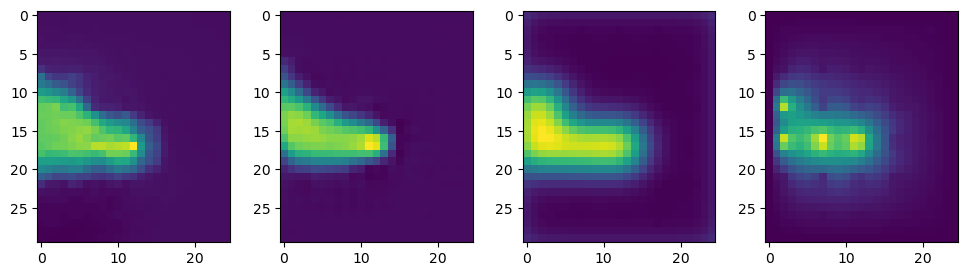

In [3]:
import torch
from utils.mapping import visualize_feature_as_image
from utils.plot_old import graph_to_image
import utils.metrics as metrics
import matplotlib.pyplot as plt

data = dataset[13370]
known_mask = data.known[:,-1]
measurements = data.y[known_mask][:,-1]
positions = data.orig_pos[known_mask]

# GNN
with torch.no_grad():
    pred_gnn = model(data)

# GDD
with torch.no_grad():
    pred_gdd = model_gdd.predict(data)

# KDM+V
model_kdm.set_measurements(positions, measurements)
pred_kdm = model_kdm.predict()

# DARES
model_dares.set_measurements(positions * 0.3, measurements)
pred_dares = model_dares.predict()

rmse_gnn = metrics.rmse(pred_gnn, data.y[:, -1].unsqueeze(1))
kld_gnn = metrics.rmse(pred_gnn, data.y[:, -1].unsqueeze(1))

rmse_gdd = metrics.rmse(pred_gdd, data.y[:, -1].reshape(30, 25))
kld_gdd = metrics.kld(pred_gdd, data.y[:, -1].reshape(30, 25))

rmse_kdm = metrics.rmse(pred_kdm, data.y[:, -1].reshape(30, 25))
kld_kdm = metrics.kld(pred_kdm, data.y[:, -1].reshape(30, 25))

rmse_dares = metrics.rmse(pred_dares, data.y[:, -1].reshape(30, 25))
kld_dares = metrics.kld(pred_dares, data.y[:, -1].reshape(30, 25))

print(f"RMSE GNN: {rmse_gnn:.4f}, KLD GNN: {kld_gnn:.4f}")
print(f"RMSE GDD: {rmse_gdd:.4f}, KLD GDD: {kld_gdd:.4f}")
print(f"RMSE KDM+V: {rmse_kdm:.4f}, KLD KDM+V: {kld_kdm:.4f}")
print(f"RMSE DARES: {rmse_dares:.4f}, KLD DARES: {kld_dares:.4f}")

# plot
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
pred_gnn_img = graph_to_image(pred_gnn, data.orig_pos)
axs[0].imshow(pred_gnn_img)
axs[1].imshow(pred_gdd.squeeze().detach())
axs[2].imshow(pred_kdm)
axs[3].imshow(pred_dares)

Metrics on whole dataset

In [6]:
import torch
torch.manual_seed(1337)

from tqdm import tqdm
import datetime

from models.rabignn_without_regularization import PLModule
from models.sota.gdd.wrapper import GasDistributionDecoder
from models.sota.kernel_dmv.wrapper import KernelDMV
from models.sota.dares.wrapper import Dares

from data.synthetic import SyntheticDataset
import torch_geometric.transforms as T
from utils.transforms import AddGridMask, Apply2DMask

CALC_GNN = True
CALC_GDD = False
CALC_KDM = False
CALC_DARES = False

# Metrics storage
rmse_gnn_values = []
rmse_gdd_values = []
rmse_kdm_values = []
rmse_dares_values = []

kld_gnn_values = []
kld_gdd_values = []
kld_kdm_values = []
kld_dares_values = []

#~~~~~~~~
#~ DATA ~
#~~~~~~~~

transform = T.Compose([
                T.Distance(norm=False),
                T.Cartesian(),
                AddGridMask(),
                Apply2DMask(),
            ])
dataset = SyntheticDataset(root="data/30x25/", type="test", radius=0.3, temporary=True, transform=transform)

#~~~~~~~~~~
#~ MODELS ~
#~~~~~~~~~~

# Load GNN
CKPT_PTH = "models/saved_models/base_reg_100/checkpoints/epoch=99-step=24800.ckpt"
CKPT_PTH = "models/logs/baseline/version_1/checkpoints/epoch=99-step=24800.ckpt"
model = PLModule.load_from_checkpoint(CKPT_PTH, map_location='cpu')
model.eval()

# Load GDD
model_gdd = GasDistributionDecoder()
model_gdd.set_normalization_params(dataset.normalization_params)

# Load KDM+V
model_kdm = KernelDMV(x_range=[0,29], y_range=[0,24], cell_size=1, kernel_size=2.5)

# Load DARES
model_dares = Dares()

#~~~~~~~~
#~ LOOP ~
#~~~~~~~~

# Process samples in dataset
n_samples = len(dataset)
for i in tqdm(range(n_samples)):
    data = dataset[i]
    known_mask = data.known[:,-1]
    measurements = data.y[known_mask][:,-1]
    positions = data.orig_pos[known_mask]

    if CALC_GNN:
        pred = model(data)

        rmse_gnn = metrics.rmse(pred, data.y[:, -1].unsqueeze(1))
        rmse_gnn_values.append(rmse_gnn.item())

        kld_gnn = metrics.kld(pred, data.y[:, -1].unsqueeze(1))
        kld_gnn_values.append(kld_gnn.item())

    if CALC_GDD:
        pred_gdd = model_gdd.predict(data)

        rmse_gdd = metrics.rmse(pred_gdd, data.y[:, -1].reshape(30, 25))
        rmse_gdd_values.append(rmse_gdd.item())

        kld_gdd = metrics.kld(pred_gdd, data.y[:, -1].reshape(30, 25))
        kld_gdd_values.append(kld_gdd.item())

    if CALC_KDM:
        model_kdm.set_measurements(positions, measurements)
        pred_kdm = model_kdm.predict()

        rmse_kdm = metrics.rmse(pred_kdm, data.y[:, -1].reshape(30, 25))
        rmse_kdm_values.append(rmse_kdm.item())

        kld_kdm = metrics.kld(pred_kdm, data.y[:, -1].reshape(30, 25))
        kld_kdm_values.append(kld_kdm.item())

    if CALC_DARES:
        model_dares.set_measurements(positions, measurements)
        pred_dares = model_dares.predict()

        rmse_dares = metrics.rmse(pred_dares, data.y[:, -1].reshape(30, 25))
        rmse_dares_values.append(rmse_dares.item())

        kld_dares = metrics.kld(pred_dares, data.y[:, -1].reshape(30, 25))
        kld_dares_values.append(kld_dares.item())

#~~~~~~~
#~ LOG ~
#~~~~~~~
# add current data in file name
file_name = "metrics_synthetic_regular_" + str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + ".txt"

with open(f"test_logs/{file_name}", "w+") as f:
    if CALC_GNN:
        f.write("Mean RMSE for GNN: " + str(sum(rmse_gnn_values) / len(rmse_gnn_values)) + "\n")
        f.write("Mean KLD for GNN: " + str(sum(kld_gnn_values) / len(kld_gnn_values)) + "\n")
    if CALC_GDD:
        f.write("Mean RMSE for GDD: " + str(sum(rmse_gdd_values) / len(rmse_gdd_values)) + "\n")
        f.write("Mean KLD for GDD: " + str(sum(kld_gdd_values) / len(kld_gdd_values)) + "\n")
    if CALC_KDM:
        f.write("Mean RMSE for KDM: " + str(sum(rmse_kdm_values) / len(rmse_kdm_values)) + "\n")
        f.write("Mean KLD for KDM: " + str(sum(kld_kdm_values) / len(kld_kdm_values)) + "\n")
    if CALC_DARES:
        f.write("Mean RMSE for DARES: " + str(sum(rmse_dares_values) / len(rmse_dares_values)) + "\n")
        f.write("Mean KLD for DARES: " + str(sum(kld_dares_values) / len(kld_dares_values)) + "\n")

/home/nwinkler/.conda/envs/pyg/lib/python3.11/site-packages/torch_geometric/data/dataset.py:242: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
100%|██████████| 23760/23760 [1:16:13<00:00,  5.20it/s]
